In [1]:
import pandas as pd
import numpy as np

# FOREST HEALTH UK #

### Uploading the data set

In [2]:

df = pd.read_csv('/Users/sandra/Desktop/Capstone/Final_clean_data_modeling.csv')
df.head()

,year,plot_type,assessment_date,assessment_type,plot_number,subplot,tree_number,species,local_crown_density,diameter_mm,...,address,country,ammonia,nitrous_oxide,sulphur_dioxide,volatile_organic_compounds,particulate_matter_10,particulate_matter_25,ann_rainfall,ann_temperature
0,1995,OK,1995-07-31,I,1,N,1,OK,15.0,875.0,...,"Farnham Road, Forest Lodge, Binsted, Frith End...",England,96.000094,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07
1,1995,OK,1995-07-31,I,1,N,2,OK,25.0,517.0,...,"Farnham Road, Forest Lodge, Binsted, Frith End...",England,96.000094,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07
2,1995,OK,1995-07-31,I,1,N,3,OK,15.0,673.0,...,"Farnham Road, Forest Lodge, Binsted, Frith End...",England,96.000094,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07
3,1995,OK,1995-07-31,I,1,N,4,OK,10.0,621.0,...,"Farnham Road, Forest Lodge, Binsted, Frith End...",England,96.000094,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07
4,1995,OK,1995-07-31,I,1,N,5,OK,25.0,1020.0,...,"Farnham Road, Forest Lodge, Binsted, Frith End...",England,96.000094,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07


In [3]:
df.shape

(46929, 63)

In [4]:
df.local_crown_density.unique()

array([15., 25., 10., 30., 55., 40., 60., 45., 20.,  5., 50., 75., 70.,
       35.,  0., 65., 80., 90., 85., 99., 95.])

In [5]:
#creating age
df['age'] = df['year'] - df['planting_year'] 

### Creating binary target variable crown density class

In [6]:
#creating mean of local crown density reduction based on tree species
mean_col = df.groupby(['year', 'species'])['local_crown_density'].mean() # don't reset the index!
df = df.set_index(['year', 'species']) # make the same index here
df['mean_col'] = mean_col
df = df.reset_index() # to take the hierarchical index off again

In [7]:
crown_mean = np.mean(df['mean_col'])
crown_mean

21.227172963409487

In [8]:
df['Crown_density_class'] = [1 if i > crown_mean else 0 for i in df.local_crown_density]
df.head()

,year,species,plot_type,assessment_date,assessment_type,plot_number,subplot,tree_number,local_crown_density,diameter_mm,...,nitrous_oxide,sulphur_dioxide,volatile_organic_compounds,particulate_matter_10,particulate_matter_25,ann_rainfall,ann_temperature,age,mean_col,Crown_density_class
0,1995,OK,OK,1995-07-31,I,1,N,1,15.0,875.0,...,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07,175,17.298236,0
1,1995,OK,OK,1995-07-31,I,1,N,2,25.0,517.0,...,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07,175,17.298236,1
2,1995,OK,OK,1995-07-31,I,1,N,3,15.0,673.0,...,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07,175,17.298236,0
3,1995,OK,OK,1995-07-31,I,1,N,4,10.0,621.0,...,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07,175,17.298236,0
4,1995,OK,OK,1995-07-31,I,1,N,5,25.0,1020.0,...,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07,175,17.298236,1


In [9]:
#saving clean data to csv
df.to_csv('Final_clean_new_data.csv', index=False)

In [10]:
from scipy import stats
import statsmodels.api as sm
import pmdarima as pmd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# MODELING

### Baseline

In [12]:
df_copy = df.copy()

In [13]:
#baseline accuracy
df.Crown_density_class.value_counts(normalize=True).max()

0.6208953951714292

In [14]:
#classification target
y = df_copy.pop('Crown_density_class')

In [15]:
y.shape

(46929,)

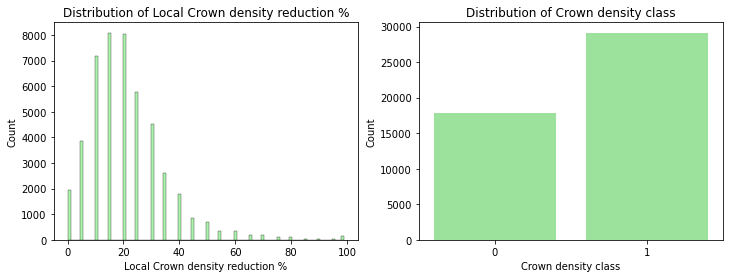

In [16]:
fig, ax = plt.subplots(ncols=2,figsize=(12,4))
sns.histplot(data = df.local_crown_density, ax=ax[0], color='lightgreen')
sns.barplot(x=['0','1'], y=[df.Crown_density_class.value_counts()[1],df.Crown_density_class.value_counts()[0]], ax=ax[1],color='lightgreen')
ax[1].set(xlabel='Crown density class')
ax[1].set(ylabel='Count')
ax[0].set(xlabel="Local Crown density reduction %")
ax[0].set_title('Distribution of Local Crown density reduction %')
ax[1].set_title('Distribution of Crown density class')
plt.show()

### Creating first set of predictors

In [17]:
X = df_copy[[ 'diameter_mm', 'height_cm', 'shoot_death_branch',
        'defoliation_type',
       'overall_discolouration', 
        'damage_butt_stem', 'damage_game',
       'damage_insect', 'damage_fungal', 'damage_abiotic', 'damage_man',
       'damage_fire', 'damage_other', 'ammonia', 'nitrous_oxide', 'sulphur_dioxide', 'volatile_organic_compounds', 'particulate_matter_10', 'particulate_matter_25','ann_temperature',       
                       
'ann_rainfall']]

In [18]:
X = pd.get_dummies(X,columns = [
       'defoliation_type',
       'overall_discolouration', 
        'damage_butt_stem', 'damage_game',
       'damage_insect', 'damage_fungal', 'damage_abiotic', 'damage_man',
       'damage_fire', 'damage_other', 'shoot_death_branch'
       ], drop_first = True)
X.columns

Index(['diameter_mm', 'height_cm', 'ammonia', 'nitrous_oxide',
       'sulphur_dioxide', 'volatile_organic_compounds',
       'particulate_matter_10', 'particulate_matter_25', 'ann_temperature',
       'ann_rainfall', 'defoliation_type_1.0', 'defoliation_type_2.0',
       'defoliation_type_3.0', 'defoliation_type_4.0', 'defoliation_type_5.0',
       'defoliation_type_6.0', 'defoliation_type_7.0', 'defoliation_type_8.0',
       'overall_discolouration_1.0', 'overall_discolouration_2.0',
       'overall_discolouration_3.0', 'overall_discolouration_4.0',
       'damage_butt_stem_1.0', 'damage_game_1.0', 'damage_game_2.0',
       'damage_insect_1.0', 'damage_insect_2.0', 'damage_insect_3.0',
       'damage_insect_4.0', 'damage_fungal_1.0', 'damage_fungal_2.0',
       'damage_fungal_3.0', 'damage_fungal_4.0', 'damage_abiotic_1.0',
       'damage_man_1.0', 'damage_fire_1.0', 'damage_other_1.0',
       'shoot_death_branch_1.0', 'shoot_death_branch_2.0',
       'shoot_death_branch_3.0', 'shoot

In [19]:
X.shape

(46929, 43)

### Creating second set of predictors

In [20]:
X2 = df_copy[[ 'diameter_mm', 'height_cm', 'shoot_death_branch',
        'defoliation_type','broadleaf_dieback_type', 'leaf_browning',                 
'leaf_yellowing',      
'broadleaf_dieback_extend_per',
       'overall_discolouration', 
        'damage_butt_stem', 'damage_game',
       'damage_insect', 'damage_fungal', 'damage_abiotic', 'damage_man',
       'damage_fire', 'damage_other', 'ammonia', 'nitrous_oxide', 'sulphur_dioxide', 'volatile_organic_compounds', 'particulate_matter_10', 'particulate_matter_25','ann_temperature',       
                       
'ann_rainfall', 'latitude','age' ]]

In [21]:
X2 = pd.get_dummies(X2,columns = [
       'defoliation_type', 'broadleaf_dieback_type', 'leaf_browning',                 
'leaf_yellowing',      
       'overall_discolouration', 
        'damage_butt_stem', 'damage_game',
       'damage_insect', 'damage_fungal', 'damage_abiotic', 'damage_man',
       'damage_fire', 'damage_other', 'shoot_death_branch'
       ], drop_first = True)
X2.columns

Index(['diameter_mm', 'height_cm', 'broadleaf_dieback_extend_per', 'ammonia',
       'nitrous_oxide', 'sulphur_dioxide', 'volatile_organic_compounds',
       'particulate_matter_10', 'particulate_matter_25', 'ann_temperature',
       'ann_rainfall', 'latitude', 'age', 'defoliation_type_1.0',
       'defoliation_type_2.0', 'defoliation_type_3.0', 'defoliation_type_4.0',
       'defoliation_type_5.0', 'defoliation_type_6.0', 'defoliation_type_7.0',
       'defoliation_type_8.0', 'broadleaf_dieback_type_1.0',
       'broadleaf_dieback_type_2.0', 'broadleaf_dieback_type_3.0',
       'broadleaf_dieback_type_4.0', 'broadleaf_dieback_type_5.0',
       'broadleaf_dieback_type_6.0', 'leaf_browning_1.0', 'leaf_browning_2.0',
       'leaf_browning_3.0', 'leaf_browning_4.0', 'leaf_browning_5.0',
       'leaf_yellowing_1.0', 'leaf_yellowing_2.0', 'leaf_yellowing_3.0',
       'leaf_yellowing_4.0', 'leaf_yellowing_5.0',
       'overall_discolouration_1.0', 'overall_discolouration_2.0',
       'overal

In [22]:
X2.shape

(46929, 62)

### Creating third set of predictors

In [23]:
x3 = df_copy

In [24]:
x3 = pd.get_dummies(x3, drop_first = True)
x3.columns

Index(['year', 'plot_number', 'tree_number', 'local_crown_density',
       'diameter_mm', 'height_cm', 'tree_dominance_class',
       'canopy_closure_class', 'defoliation_type', 'broadleaf_dieback_type',
       ...
       'address_Woodditton, Ditton Green, Cambridgeshire, East of England, England, United Kingdom',
       'address_Woodlands, Honey Hill, Blean, Canterbury, Kent, South East England, England, CT2 9JW, United Kingdom',
       'address_Woodside Court, Dalbeattie, Dumfries and Galloway, Scotland, DG5 4NX, United Kingdom',
       'address_Wytham Woods, Middle Ride, Wytham, Vale of White Horse, Oxfordshire, South East England, England, OX2 8QQ, United Kingdom',
       'address_Yardley Hastings, West Northamptonshire, East Midlands, England, United Kingdom',
       'address_Ynys Hir Hide, A487, Ysgubor-y-coed, Ffwrnais / Furnace, Ceredigion, Cymru / Wales, SY20 8ND, United Kingdom',
       'address_Ystradfellte, Pontneddfechan, Powys, Cymru / Wales, SA11 5UP, United Kingdom',
  

### Applying the models

In [25]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


def docm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if labels is not None:
        cols = ['p_'+c for c in labels]
        df = pd.DataFrame(cm, index=labels, columns=cols)
    else:
        cols = ['p_'+str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=cols)
    return df

# MODELING WITHOUT TREATING CLASS IMBALANCE 

### Model set 1 - X

In [27]:
#models to be used
models = [KNeighborsClassifier(),
          LogisticRegression(multi_class='ovr', max_iter=1000),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]
#setting target and predictors
#y = df.Crown_density_class
X = X
#train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
     random_state=1)

print('Models:')
#standarizing with standard scaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

res = []

for model in models:
    print(model)
    print()
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    print('train score:', train_score)
    test_score = model.score(X_test, y_test)
    print('test score:', test_score)
    cross_val = cross_val_score(model, X_train, y_train, cv=5,n_jobs=3)
    print('cross val score:', cross_val)
    cross_val_mean = cross_val_score(model, X_train, y_train, cv=5, n_jobs=3).mean()
    print('cross val mean score:', cross_val_mean)
    y_pred = model.predict(X_test)
    print()
    cm = docm(y_test, y_pred)
    print('Confusion matrix')
    print(cm)
    print()
    print('Classification report')
    print(classification_report(y_test, y_pred))
    print()
    res.append([model,train_score, test_score,cross_val, cross_val_mean])
    print()
    print('-'*60)
    print()

Models:
KNeighborsClassifier()

train score: 0.7996430759395893
test score: 0.7075431493714042
cross val score: [0.70209082 0.70195765 0.7062192  0.6951252  0.71696857]
cross val mean score: 0.7044722890868731

Confusion matrix
    p_0   p_1
0  4607  1195
1  1550  2034

Classification report
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      5802
           1       0.63      0.57      0.60      3584

    accuracy                           0.71      9386
   macro avg       0.69      0.68      0.68      9386
weighted avg       0.70      0.71      0.70      9386



------------------------------------------------------------

LogisticRegression(max_iter=1000, multi_class='ovr')

train score: 0.7127826758650081
test score: 0.7136160238653313
cross val score: [0.71514183 0.70115861 0.71420962 0.70364944 0.72309536]
cross val mean score: 0.7114509720283804

Confusion matrix
    p_0   p_1
0  4827   975
1  1713  1871

Classification report
 

### Model set 2 - X2

In [28]:
models2 = [KNeighborsClassifier(),
          LogisticRegression(multi_class='ovr', max_iter=1000),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]

#target and predictors
#y = df.Crown_density_class
X2 = X2


#train test split
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y, test_size=0.2,
     random_state=1)


print('Models:')
#standarizing with standard scaler
scaler = StandardScaler()
X2_train = pd.DataFrame(scaler.fit_transform(X2_train), columns=X2.columns)
X2_test = pd.DataFrame(scaler.transform(X2_test), columns=X2.columns)

res2 = []

for model in models2:
    print(model)
    print()
    model.fit(X2_train, y2_train)
    train_score = model.score(X2_train, y2_train)
    print('train score:', train_score)
    test_score = model.score(X2_test, y2_test)
    print('test score:', test_score)
    cross_val = cross_val_score(model, X2_train, y2_train, cv=5,n_jobs=3)
    print('cross val score:', cross_val)
    cross_val_mean = cross_val_score(model, X2_train, y2_train, cv=5, n_jobs=3).mean()
    print('cross val mean score:', cross_val_mean)
    y2_pred = model.predict(X2_test)
    print()
    cm = docm(y2_test, y2_pred)
    print('Confusion matrix')
    print(cm)
    print()
    print('Classification report')
    print(classification_report(y2_test, y2_pred))
    print()
    res2.append([model,train_score, test_score,cross_val, cross_val_mean])
    print()
    print('-'*60)
    print()

Models:
KNeighborsClassifier()

train score: 0.8140532189755747
test score: 0.7275729810355849
cross val score: [0.71966973 0.71727261 0.72659475 0.72269579 0.73215237]
cross val mean score: 0.7236770501574633

Confusion matrix
    p_0   p_1
0  4759  1043
1  1514  2070

Classification report
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      5802
           1       0.66      0.58      0.62      3584

    accuracy                           0.73      9386
   macro avg       0.71      0.70      0.70      9386
weighted avg       0.72      0.73      0.72      9386



------------------------------------------------------------

LogisticRegression(max_iter=1000, multi_class='ovr')

train score: 0.7353168366939243
test score: 0.7415299382058385
cross val score: [0.73538421 0.72473032 0.73445199 0.73068727 0.74560469]
cross val mean score: 0.734171695084705

Confusion matrix
    p_0   p_1
0  4958   844
1  1582  2002

Classification report
  

### Model set 3 - X3

In [29]:
models3 = [KNeighborsClassifier(),
          LogisticRegression(multi_class='ovr', max_iter=1000),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]

#target and predictors
#y = df.Crown_density_class
x3 = x3

#train test split
x3_train, x3_test, y3_train, y3_test = train_test_split(
    x3, y, test_size=0.2,
     random_state=1)

print("Models:")
#standarizing with standard scaler
scaler = StandardScaler()
x3_train = pd.DataFrame(scaler.fit_transform(x3_train), columns=x3.columns)
x3_test = pd.DataFrame(scaler.transform(x3_test), columns=x3.columns)

res3 = []

for model in models3:
    print(model)
    print()
    model.fit(x3_train, y3_train)
    train_score = model.score(x3_train, y3_train)
    print('train score:', train_score)
    test_score = model.score(x3_test, y3_test)
    print('test score:', test_score)
    cross_val = cross_val_score(model, x3_train, y3_train, cv=5, n_jobs=3)
    print('cross val score:', cross_val)
    cross_val_mean = cross_val_score(model, x3_train, y3_train, cv=5, n_jobs =3).mean()
    print('cross val mean score:', cross_val_mean)
    y3_pred = model.predict(x3_test)
    print()
    cm = docm(y3_test, y3_pred)
    print('Confusion matrix')
    print(cm)
    print()
    print('Classification report')
    print(classification_report(y3_test, y3_pred))
    print()
    res3.append([model,train_score, test_score,cross_val, cross_val_mean])
    print()
    print('-'*60)
    print()

Models:
KNeighborsClassifier()

train score: 0.8238020403270916
test score: 0.7338589388450885
cross val score: [0.72180051 0.74177653 0.7359169  0.72895578 0.72908897]
cross val mean score: 0.7315077385737718

Confusion matrix
    p_0   p_1
0  4872   930
1  1568  2016

Classification report
              precision    recall  f1-score   support

           0       0.76      0.84      0.80      5802
           1       0.68      0.56      0.62      3584

    accuracy                           0.73      9386
   macro avg       0.72      0.70      0.71      9386
weighted avg       0.73      0.73      0.73      9386



------------------------------------------------------------

LogisticRegression(max_iter=1000, multi_class='ovr')

train score: 1.0
test score: 0.9938205838482846
cross val score: [0.99147689 0.99267546 0.99041151 0.99014385 0.99307405]
cross val mean score: 0.9915563515221975

Confusion matrix
    p_0   p_1
0  5781    21
1    37  3547

Classification report
              pr

# MODELING - APPLYING SMOTE OVERSAMPLING 

In [30]:
from collections import Counter

### Model set 4 - X

In [31]:
#models to be used
models4 = [KNeighborsClassifier(),
          LogisticRegression(multi_class='ovr', max_iter=1000),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]
#setting target and predictors
#y = df.Crown_density_class
X4 = X
#train test split
X4_train, X4_test, y4_train, y4_test = train_test_split(
    X4, y, test_size=0.2,
     random_state=1)

#counting y before SMOTE
counter = Counter(y4_train)
print('Class balance before SMOTE',counter)

#applying SMOTE to avoid class imbalance
oversample = SMOTE()
X4_train,y4_train = oversample.fit_resample(X4_train, y4_train)

#counting y after SMOTE
counter = Counter(y4_train)
print('Class balance after SMOTE',counter)
print()
print()
print('Models:')
#standarizing with standard scaler
scaler = StandardScaler()
X4_train = pd.DataFrame(scaler.fit_transform(X4_train), columns=X4.columns)
X4_test = pd.DataFrame(scaler.transform(X4_test), columns=X4.columns)

res4 = []

for model in models4:
    print(model)
    print()
    model.fit(X4_train, y4_train)
    train_score = model.score(X4_train, y4_train)
    print('train score:', train_score)
    test_score = model.score(X4_test, y4_test)
    print('test score:', test_score)
    cross_val = cross_val_score(model, X4_train, y4_train, cv=5,n_jobs=3)
    print('cross val score:', cross_val)
    cross_val_mean = cross_val_score(model, X4_train, y4_train, cv=5,n_jobs=3).mean()
    print('cross val mean score:', cross_val_mean)
    y4_pred = model.predict(X4_test)
    print()
    cm = docm(y4_test, y4_pred)
    print('Confusion matrix')
    print(cm)
    print()
    print('Classification report')
    print(classification_report(y4_test, y4_pred))
    res4.append([model,train_score, test_score,cross_val, cross_val_mean])
    print()
    print('-'*60)
    print()

Class balance before SMOTE Counter({0: 23336, 1: 14207})
Class balance after SMOTE Counter({0: 23336, 1: 23336})


Models:
KNeighborsClassifier()

train score: 0.8052579705176551
test score: 0.6679096526741957
cross val score: [0.64809855 0.64692019 0.64613242 0.76033855 0.76858796]
cross val mean score: 0.6940155342029858

Confusion matrix
    p_0   p_1
0  4128  1674
1  1443  2141

Classification report
              precision    recall  f1-score   support

           0       0.74      0.71      0.73      5802
           1       0.56      0.60      0.58      3584

    accuracy                           0.67      9386
   macro avg       0.65      0.65      0.65      9386
weighted avg       0.67      0.67      0.67      9386


------------------------------------------------------------

LogisticRegression(max_iter=1000, multi_class='ovr')

train score: 0.6970560507370587
test score: 0.6459620711698274
cross val score: [0.60942689 0.61874665 0.6104564  0.75433898 0.76119563]
cross val m

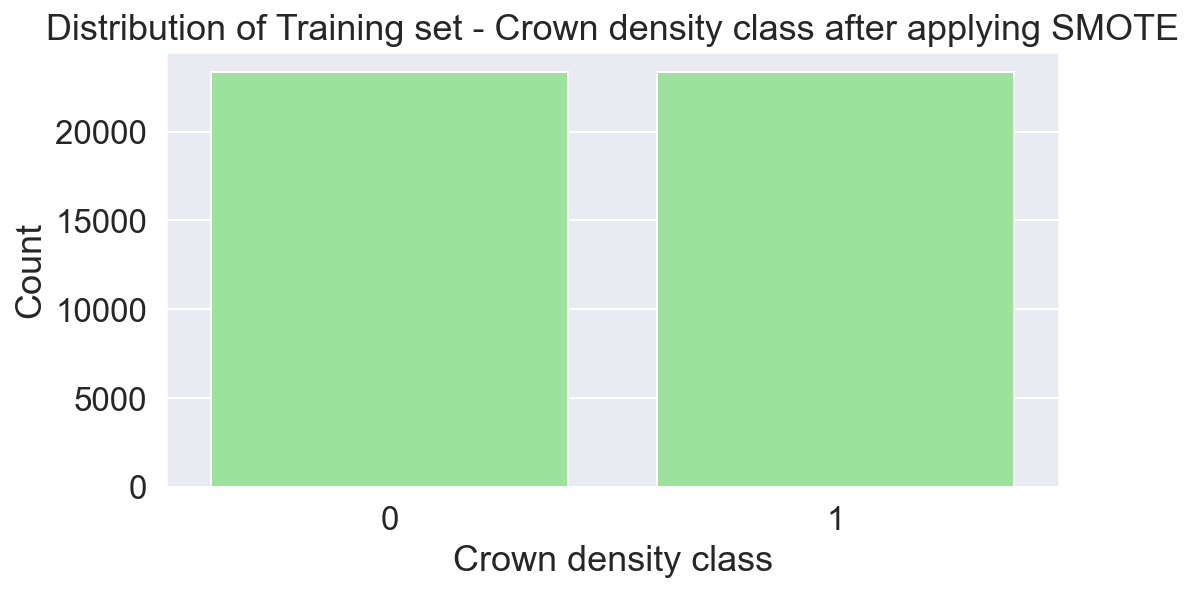

In [57]:
fig, ax = plt.subplots(ncols=1,figsize=(6,4))
sns.barplot(x=['0','1'], y=[y4_train.value_counts()[1],y4_train.value_counts()[0]], ax=ax,color='lightgreen')
ax.set(xlabel='Crown density class')
ax.set(ylabel='Count')
ax.set_title('Distribution of Training set - Crown density class after applying SMOTE')
plt.show();

### Model set 5  - X2

In [33]:
models5 = [KNeighborsClassifier(),
          LogisticRegression(multi_class='ovr', max_iter=1000),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]

#target and predictors
#y = df.Crown_density_class
X5 = X2


#train test split
X5_train, X5_test, y5_train, y5_test = train_test_split(
    X5, y, test_size=0.2,
     random_state=1)

#counting y before SMOTE
counter = Counter(y5_train)
print('Class balance before SMOTE',counter)


#applying SMOTE to avoid class imbalance
oversample = SMOTE()
X5_train,y5_train = oversample.fit_resample(X5_train, y5_train)

#counting y after SMOTE
counter = Counter(y5_train)
print('Class balance after SMOTE',counter)
print()
print()
print('Models:')
#standarizing with standard scaler
scaler = StandardScaler()
X5_train = pd.DataFrame(scaler.fit_transform(X5_train), columns=X5.columns)
X5_test = pd.DataFrame(scaler.transform(X5_test), columns=X5.columns)

res5 = []

for model in models5:
    print(model)
    print()
    model.fit(X5_train, y5_train)
    train_score = model.score(X5_train, y5_train)
    print('train score:', train_score)
    test_score = model.score(X5_test, y5_test)
    print('test score:', test_score)
    cross_val = cross_val_score(model, X5_train, y5_train, cv=5,n_jobs=3)
    print('cross val score:', cross_val)
    cross_val_mean = cross_val_score(model, X5_train, y5_train, cv=5,n_jobs=3).mean()
    print('cross val mean score:', cross_val_mean)
    y5_pred = model.predict(X5_test)
    print()
    print()
    cm = docm(y5_test, y5_pred)
    print('Confusion matrix')
    print(cm)
    print()
    print('Classification report')
    print(classification_report(y5_test, y5_pred))
    res5.append([model,train_score, test_score,cross_val, cross_val_mean])
    print()
    print('-'*60)
    print()

Class balance before SMOTE Counter({0: 23336, 1: 14207})
Class balance after SMOTE Counter({0: 23336, 1: 23336})


Models:
KNeighborsClassifier()

train score: 0.8274768597874529
test score: 0.7033880247176646
cross val score: [0.68741296 0.67305838 0.67709449 0.79644311 0.8015856 ]
cross val mean score: 0.7271189099776215


Confusion matrix
    p_0   p_1
0  4423  1379
1  1405  2179

Classification report
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      5802
           1       0.61      0.61      0.61      3584

    accuracy                           0.70      9386
   macro avg       0.69      0.69      0.69      9386
weighted avg       0.70      0.70      0.70      9386


------------------------------------------------------------

LogisticRegression(max_iter=1000, multi_class='ovr')

train score: 0.7378942406582105
test score: 0.6963562753036437
cross val score: [0.66266738 0.66630959 0.66745232 0.78015856 0.79644311]
cross val 

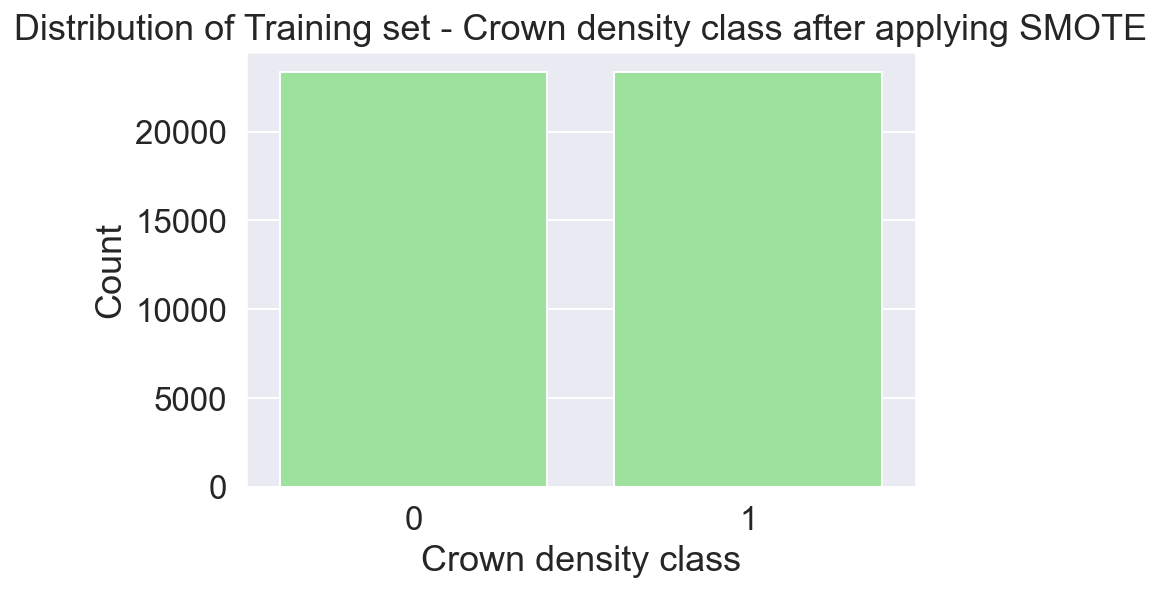

In [59]:
fig, ax = plt.subplots(ncols=1,figsize=(6,4))
sns.barplot(x=['0','1'], y=[y4_train.value_counts()[1],y4_train.value_counts()[0]], ax=ax,color='lightgreen')
ax.set(xlabel='Crown density class')
ax.set(ylabel='Count')
ax.set_title('Distribution of Training set - Crown density class after applying SMOTE')
plt.show();

### Model set 6 - X3

In [35]:
models6 = [KNeighborsClassifier(),
          LogisticRegression(multi_class='ovr', max_iter=1000),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]

#target and predictors
#y = df.Crown_density_class
x6 = x3

#train test split
x6_train, x6_test, y6_train, y6_test = train_test_split(
    x6, y, test_size=0.2,
     random_state=1)

#counting y before SMOTE
counter = Counter(y6_train)
print('Class balance before SMOTE',counter)

#applying SMOTE to avoid class imbalance
oversample = SMOTE()
x6_train,y6_train = oversample.fit_resample(x6_train, y6_train)

#counting y after SMOTE
counter = Counter(y6_train)
print('Class balance after SMOTE',counter)
print()
print()
print('Models:')
#standarizing with standard scaler
scaler = StandardScaler()
x6_train = pd.DataFrame(scaler.fit_transform(x6_train), columns=x6.columns)
x6_test = pd.DataFrame(scaler.transform(x6_test), columns=x6.columns)

res6 = []

for model in models6:
    print(model)
    print()
    model.fit(x6_train, y6_train)
    train_score = model.score(x6_train, y6_train)
    print('train score:', train_score)
    test_score = model.score(x6_test, y6_test)
    print('test score:', test_score)
    cross_val = cross_val_score(model, x6_train, y6_train, cv=5,n_jobs=3)
    print('cross val score:', cross_val)
    cross_val_mean = cross_val_score(model, x6_train, y6_train, cv=5,n_jobs=3).mean()
    print('cross val mean score:', cross_val_mean)
    y6_pred = model.predict(x6_test)
    print()
    cm = docm(y6_test, y6_pred)
    print('Confusion matrix')
    print(cm)
    print()
    print('Classification report')
    print(classification_report(y6_test, y6_pred))
    res6.append([model,train_score, test_score,cross_val, cross_val_mean])
    print()
    print('-'*60)
    print()

Class balance before SMOTE Counter({0: 23336, 1: 14207})
Class balance after SMOTE Counter({0: 23336, 1: 23336})


Models:
KNeighborsClassifier()

train score: 0.8254199520054851
test score: 0.6798423183464735
cross val score: [0.69426888 0.70840921 0.69498607 0.793979   0.7994429 ]
cross val mean score: 0.7382172128113735

Confusion matrix
    p_0   p_1
0  3866  1936
1  1069  2515

Classification report
              precision    recall  f1-score   support

           0       0.78      0.67      0.72      5802
           1       0.57      0.70      0.63      3584

    accuracy                           0.68      9386
   macro avg       0.67      0.68      0.67      9386
weighted avg       0.70      0.68      0.68      9386


------------------------------------------------------------

LogisticRegression(max_iter=1000, multi_class='ovr')

train score: 1.0
test score: 0.9925420839548263
cross val score: [0.98853776 0.98907338 0.98778659 0.99442897 0.99507178]
cross val mean score: 0.99

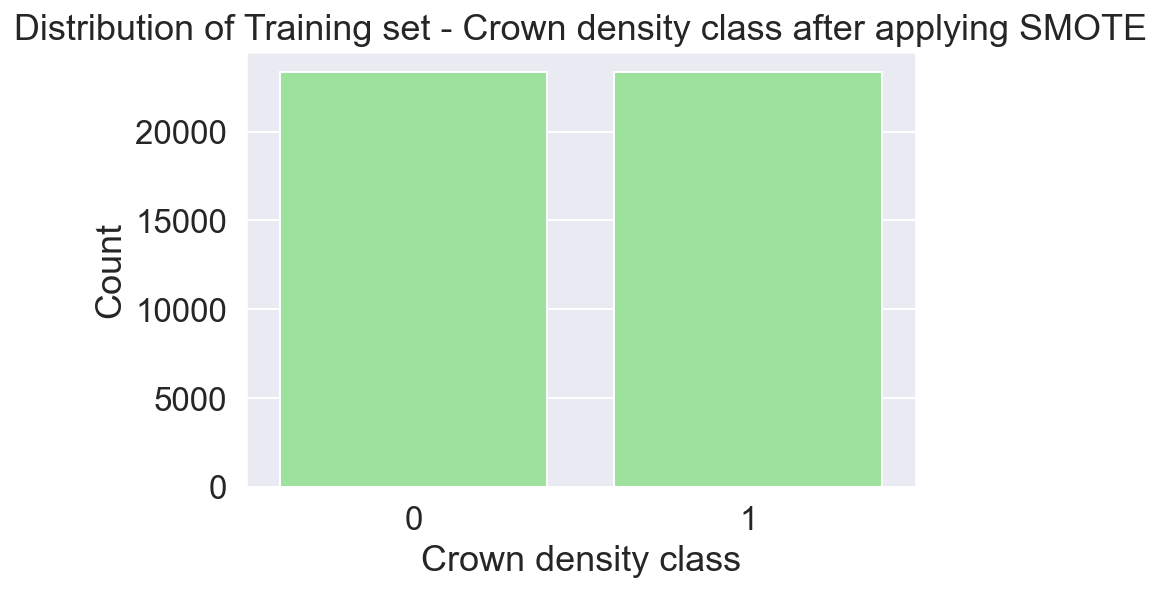

In [60]:
fig, ax = plt.subplots(ncols=1,figsize=(6,4))
sns.barplot(x=['0','1'], y=[y4_train.value_counts()[1],y4_train.value_counts()[0]], ax=ax,color='lightgreen')
ax.set(xlabel='Crown density class')
ax.set(ylabel='Count')
ax.set_title('Distribution of Training set - Crown density class after applying SMOTE')
plt.show();

### Applying Grid Search CV on the best performing model across 3 model sets

In [37]:
from sklearn.model_selection import GridSearchCV

In [38]:
model = LogisticRegression(multi_class='ovr', max_iter=1000)
list(model.get_params().keys())

['C',
 'class_weight',
 'dual',
 'fit_intercept',
 'intercept_scaling',
 'l1_ratio',
 'max_iter',
 'multi_class',
 'n_jobs',
 'penalty',
 'random_state',
 'solver',
 'tol',
 'verbose',
 'warm_start']

In [39]:
model = LogisticRegression(multi_class='ovr')
params = {'C': np.logspace(-4, 4, 10),
          'max_iter': [1000],
          'penalty': ['l2'],
          'fit_intercept': [True, False]}


gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  cv=5,
                  scoring='accuracy',
                  return_train_score=True)

gs.fit(X5_train, y5_train)

# extract the grid search results

print('Best Parameters:')
print(gs.best_params_)
print('Best estimator C:')
print(gs.best_estimator_.C)
print('Best estimator mean cross validated training score:')
print(gs.best_score_)
print('Best estimator score on the full training set:')
print(gs.score(X5_train, y5_train))
print('Best estimator score on the test set:')
print(gs.score(X5_test, y5_test))
print('Best estimator coefficients:')
print(gs.best_estimator_.coef_)

Best Parameters:
{'C': 0.046415888336127774, 'fit_intercept': True, 'max_iter': 1000, 'penalty': 'l2'}
Best estimator C:
0.046415888336127774
Best estimator mean cross validated training score:
0.7152276138206825
Best estimator score on the full training set:
0.7372514569763455
Best estimator score on the test set:
0.6958235670147027
Best estimator coefficients:
[[-0.36170118 -0.0148375   1.28606578  0.20091249 -0.7218725   0.48281126
   0.08410815 -0.8045121   0.29397651 -0.41932589 -0.25477487 -0.17084139
   0.29613765 -0.3063531  -0.55028509 -0.12820048  0.11988439  0.04919941
  -0.19399508  0.04208448  0.01442302 -0.11113794 -0.09657245 -0.07304031
  -0.00695657 -0.20896331 -0.47085118 -0.11976147 -0.18815217 -0.13469695
   0.11279292 -0.47085118 -0.07341619 -0.07067795 -0.05432254 -0.04488688
  -0.47085118 -0.02724683  0.10463717  0.12731295  0.26888689 -0.02611316
   0.01496002  0.04022326 -0.50629161 -0.42417882 -0.28173179 -0.04344179
  -0.09602829 -0.07047578 -0.06975886  0.00

In [40]:
pd.DataFrame(gs.cv_results_).sort_values(by=['mean_test_score', 'std_test_score'], ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_fit_intercept,param_max_iter,param_penalty,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
6,0.407408,0.013278,0.003797,0.001093,0.046416,True,1000,l2,"{'C': 0.046415888336127774, 'fit_intercept': T...",0.662667,...,0.715228,0.062087,1,0.755551,0.753756,0.753602,0.720660,0.717018,0.740117,0.017426
8,0.663502,0.039515,0.003078,0.000182,0.359381,True,1000,l2,"{'C': 0.3593813663804626, 'fit_intercept': Tru...",0.662775,...,0.714885,0.060962,2,0.755899,0.754667,0.754058,0.721544,0.718008,0.740835,0.017241
12,1.093861,0.279834,0.003643,0.000585,21.544347,True,1000,l2,"{'C': 21.54434690031882, 'fit_intercept': True...",0.663417,...,0.714692,0.060029,3,0.756033,0.754453,0.754781,0.721651,0.718196,0.741023,0.017270
14,0.549849,0.056998,0.003190,0.000412,166.810054,True,1000,l2,"{'C': 166.81005372000558, 'fit_intercept': Tru...",0.663631,...,0.714692,0.060026,4,0.755953,0.754587,0.754754,0.721651,0.718196,0.741028,0.017273
16,0.627860,0.088099,0.003108,0.000103,1291.549665,True,1000,l2,"{'C': 1291.5496650148827, 'fit_intercept': Tru...",0.663524,...,0.714649,0.060016,5,0.755926,0.754479,0.754727,0.721651,0.718357,0.741028,0.017205
18,0.562357,0.071534,0.003004,0.000146,10000.0,True,1000,l2,"{'C': 10000.0, 'fit_intercept': True, 'max_ite...",0.663524,...,0.714649,0.059970,6,0.755979,0.754533,0.754727,0.721597,0.718330,0.741033,0.017242
10,1.085435,0.132044,0.003189,0.000247,2.782559,True,1000,l2,"{'C': 2.782559402207126, 'fit_intercept': True...",0.662453,...,0.714628,0.060265,7,0.755819,0.754694,0.754566,0.721463,0.718250,0.740958,0.017265
4,0.235249,0.017153,0.003573,0.000464,0.005995,True,1000,l2,"{'C': 0.005994842503189409, 'fit_intercept': T...",0.661382,...,0.714435,0.062829,8,0.754212,0.751640,0.752263,0.719428,0.715678,0.738644,0.017282
5,0.232415,0.016680,0.003383,0.000421,0.005995,False,1000,l2,"{'C': 0.005994842503189409, 'fit_intercept': F...",0.660311,...,0.711671,0.061633,9,0.755015,0.753542,0.752772,0.718865,0.714446,0.738928,0.018253
7,0.428800,0.038602,0.003703,0.000773,0.046416,False,1000,l2,"{'C': 0.046415888336127774, 'fit_intercept': F...",0.662667,...,0.710942,0.059664,10,0.755738,0.755069,0.754191,0.719080,0.714179,0.739651,0.018868


In [41]:
best_model = LogisticRegression(C = 0.005994842503189409, fit_intercept = True, penalty = 'l2', max_iter=1000)
best_model.fit(X5_train, y5_train)
test_score = best_model.score(X5_test, y5_test)
train_score = best_model.score(X5_train, y5_train)
print('test score:', test_score)
print('train score', train_score)

test score: 0.6924142339654805
train score 0.7366943777853959


In [42]:
predictions = best_model.predict(X5_test)

### Model Evaluation

In [43]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
import scikitplot as skplt

In [44]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [45]:
df_coef = pd.DataFrame(best_model.coef_.T, index=X5_train.columns,
                       columns=['importance'])
#  values of the coefficients
df_coef.sort_values(by = 'importance', ascending = False)

,importance
broadleaf_dieback_extend_per,1.138702
age,0.269924
overall_discolouration_4.0,0.181197
ammonia,0.158796
defoliation_type_4.0,0.123687
shoot_death_branch_5.0,0.113510
overall_discolouration_3.0,0.111766
overall_discolouration_2.0,0.087978
shoot_death_branch_4.0,0.060069
defoliation_type_5.0,0.050539


In [46]:
df_coef['coef_abs'] = df_coef.importance.abs()
df_coef

,importance,coef_abs
diameter_mm,-0.338754,0.338754
height_cm,-0.014053,0.014053
broadleaf_dieback_extend_per,1.138702,1.138702
ammonia,0.158796,0.158796
nitrous_oxide,-0.155274,0.155274
sulphur_dioxide,0.033020,0.033020
volatile_organic_compounds,0.006422,0.006422
particulate_matter_10,-0.382466,0.382466
particulate_matter_25,-0.088012,0.088012
ann_temperature,-0.288539,0.288539


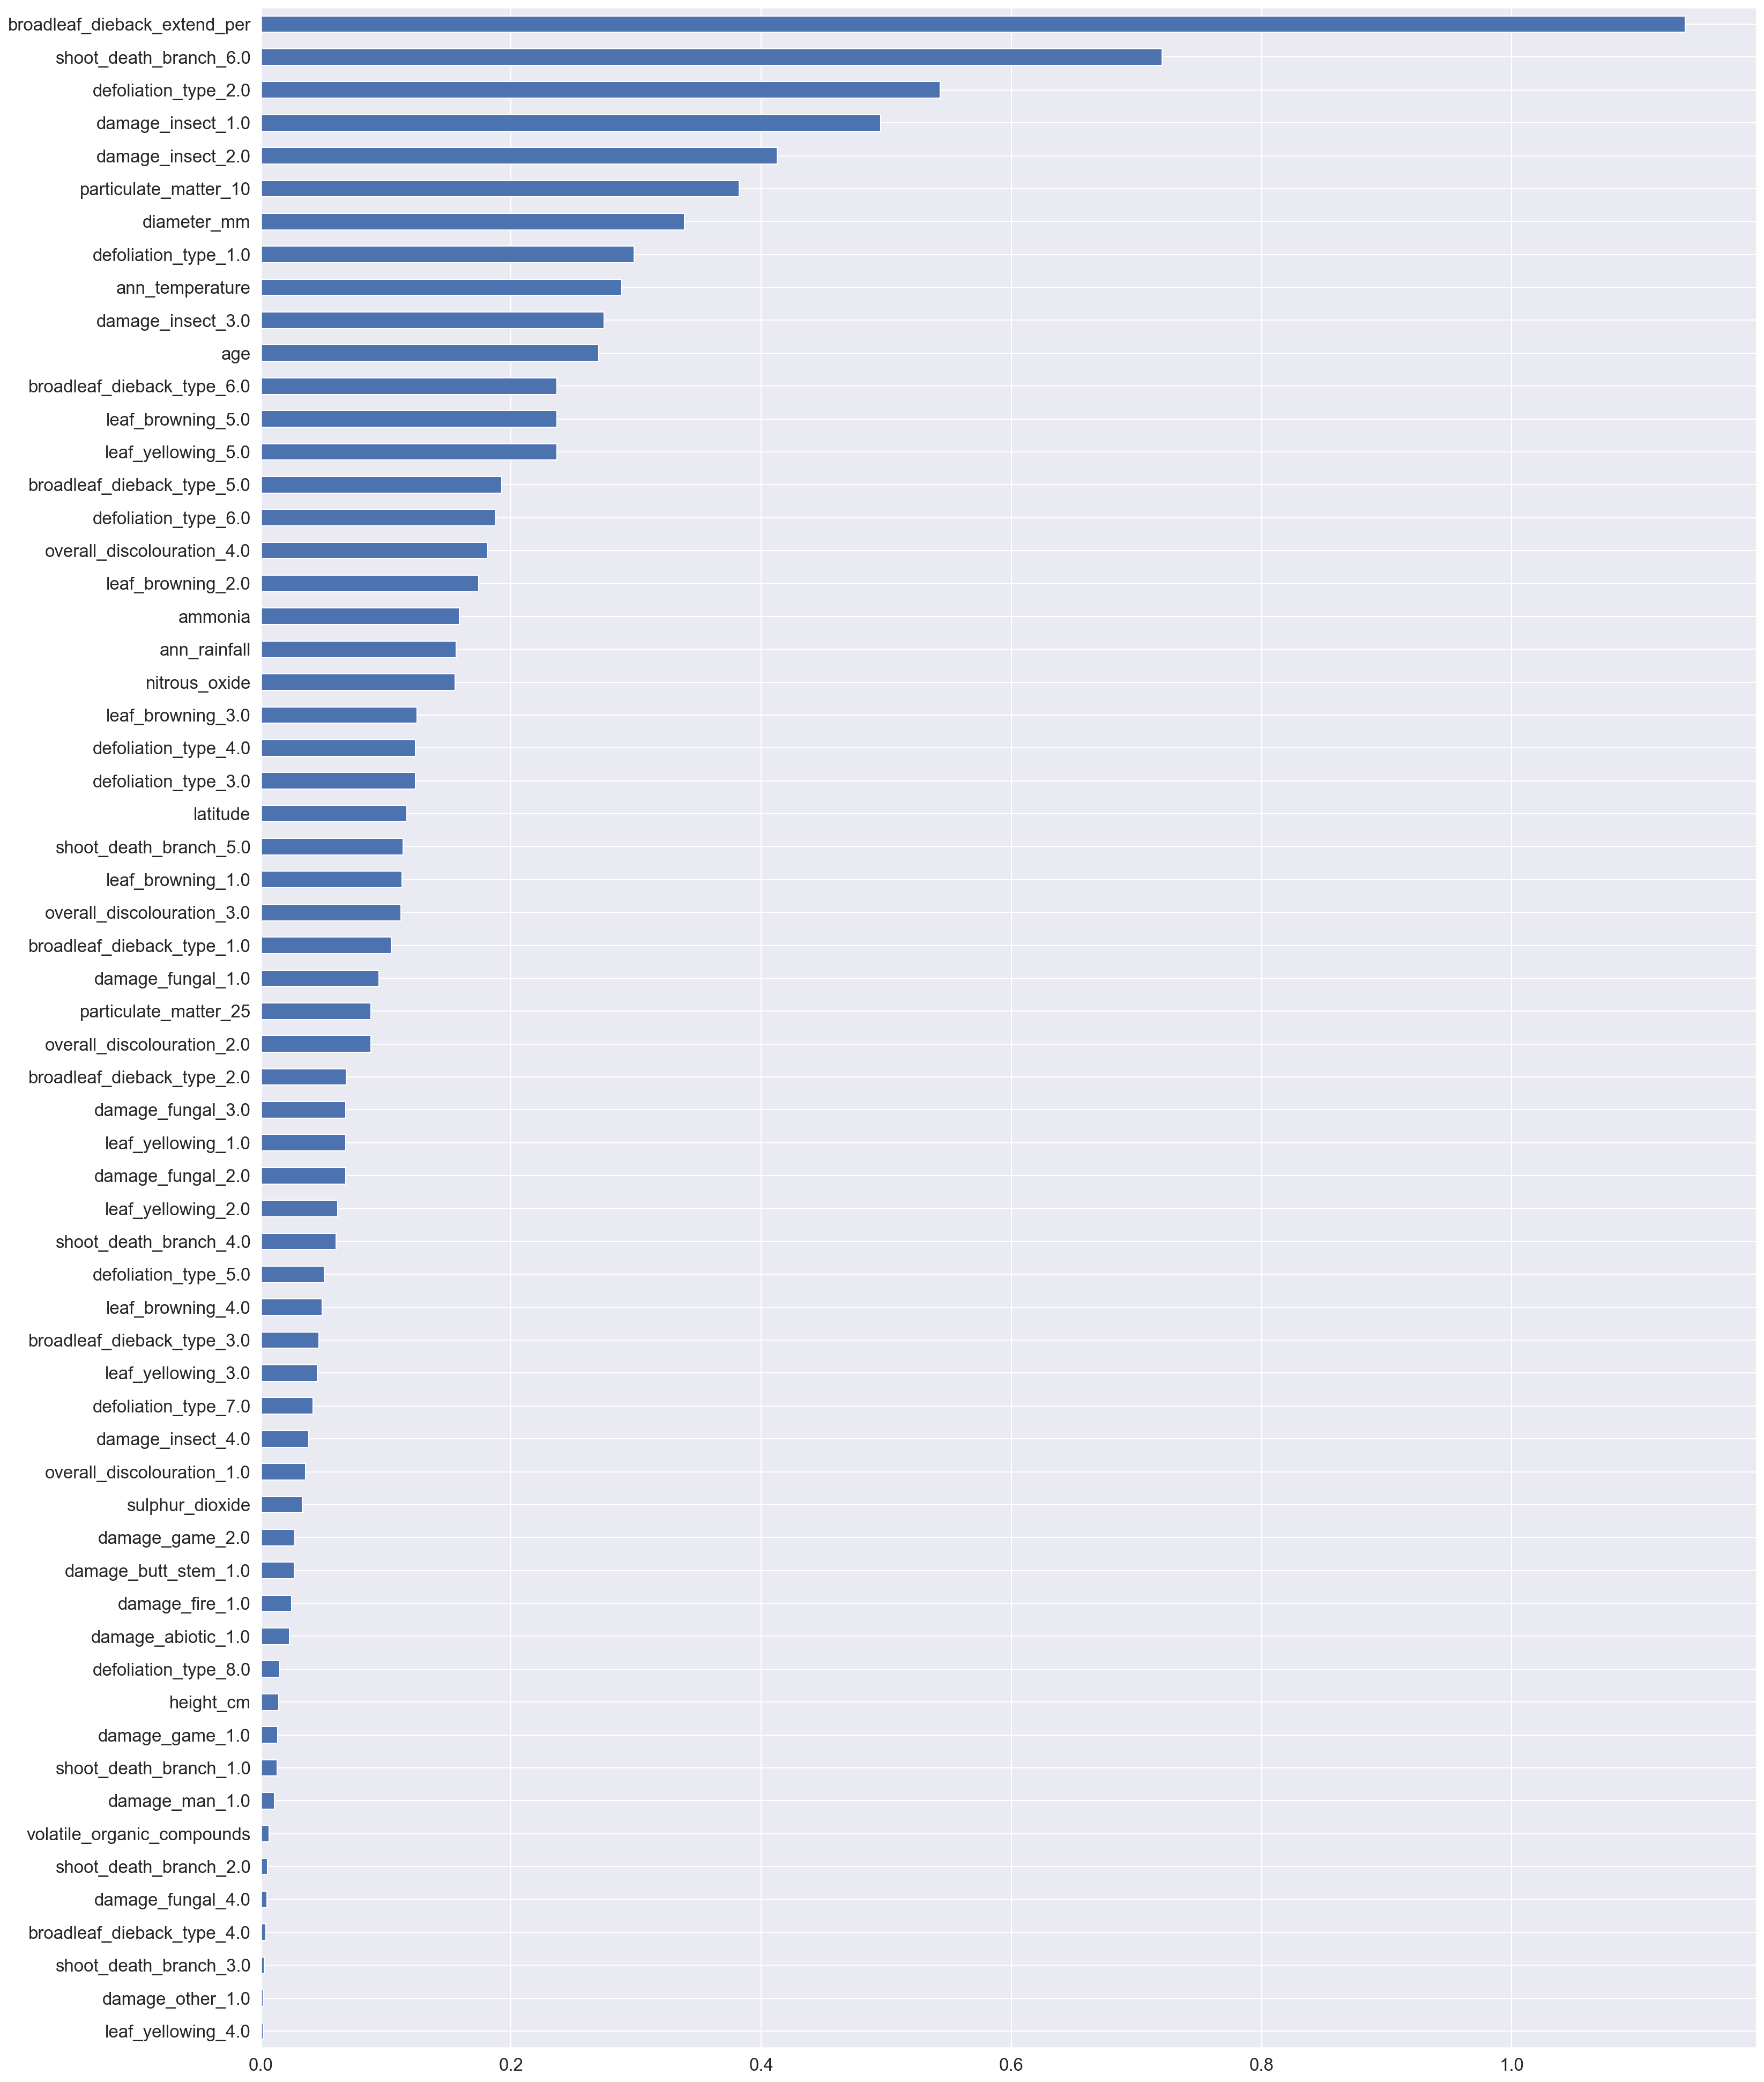

In [47]:
df_coef['coef_abs'].sort_values().plot(kind='barh', figsize=(25, 35));

In [48]:
predictions = best_model.predict(X5_test)
confusion = confusion_matrix(y5_test, predictions, labels=[1, 0])
pd.DataFrame(confusion,
             columns=['predicted_tree_deterioration', 'predicted_healthy_tree'],
             index=['True_tree_deterioration', 'True_healthy_tree'])

,predicted_tree_deterioration,predicted_healthy_tree
True_tree_deterioration,2140,1444
True_healthy_tree,1443,4359


The classification matrix resulted in:
* 2140 true positive predictions 
* 4359 true negative predictions 
* 1444 false positive predictions
* 1443 false negative predictions

The matrix is very useful in checking performance of the model. Its features enable to look at important performance measures, that help to justify the model.

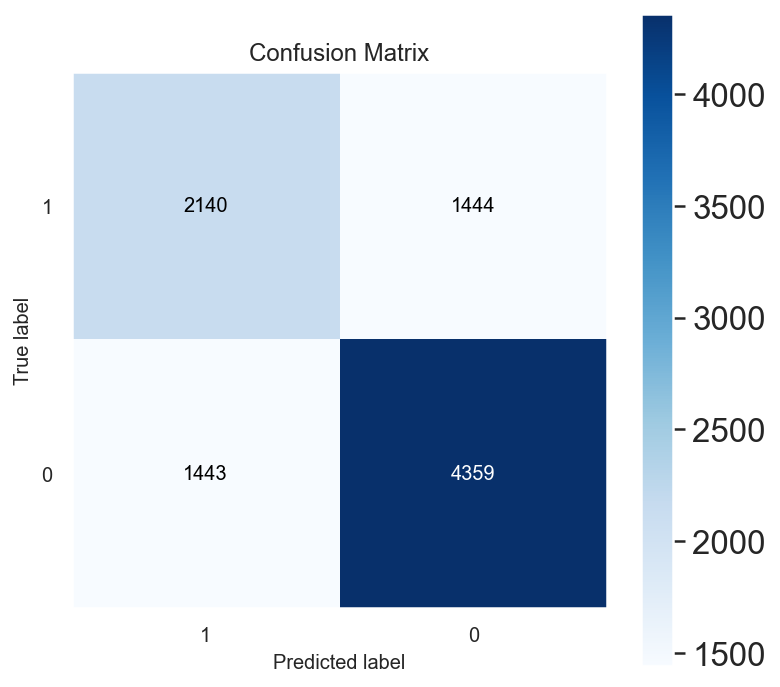

In [49]:
skplt.metrics.plot_confusion_matrix(y5_test, predictions, labels=[1, 0], figsize=(6, 6))
plt.show()

In [50]:
print(classification_report(y5_test, predictions))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      5802
           1       0.60      0.60      0.60      3584

    accuracy                           0.69      9386
   macro avg       0.67      0.67      0.67      9386
weighted avg       0.69      0.69      0.69      9386



Precision shows what proportion of positive class were actually positive and in our model its 75 % in class 0 and 60 % in class 1 .

Recall in here is 0.75 for low class - healthy tree and 0.60 for high class - deteriorating tree, meaning 75 % and 60 % of samples were correctly predicted.
In our case meaning 75% of our variables were correctly identified as predictor of healthy trees and 60% of variable samples were correctly identified as predictor of deteriorating trees.

Accuracy shows the fraction of total samples that were correctly classified and in this model its 69%, therefore the missclassification rate is 0.31 - 31%, which explains some of the unecxpected results. For Instance, Level of 60-99% overall discolouration in neddles/trees  were identified by the model as not a strong predictor of tree deterioration.

In [51]:
probabilities_train = best_model.predict_proba(X5_train)
probabilities_test = best_model.predict_proba(X5_test)

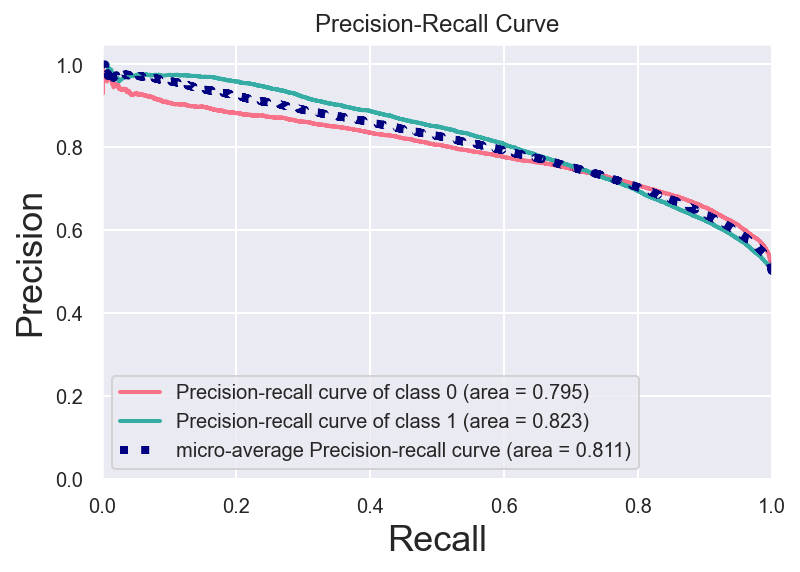

In [52]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", len(best_model.classes_)))
skplt.metrics.plot_precision_recall(y5_train, probabilities_train, cmap=cmap)
plt.show()

This Precission recall curve shows the trade off between precission and recall for different threshold. It measures how successfull prediction is when classes are very imbalanced. A high area under the curve represents both high recall and high precission, where high precission indicate a low false positive rate and a high recall indicate low false negative rate. The graph shows very high AUC scores, confirming the model can be trusted in predicting tree condition based on the majority of the predictors chosen for the model.

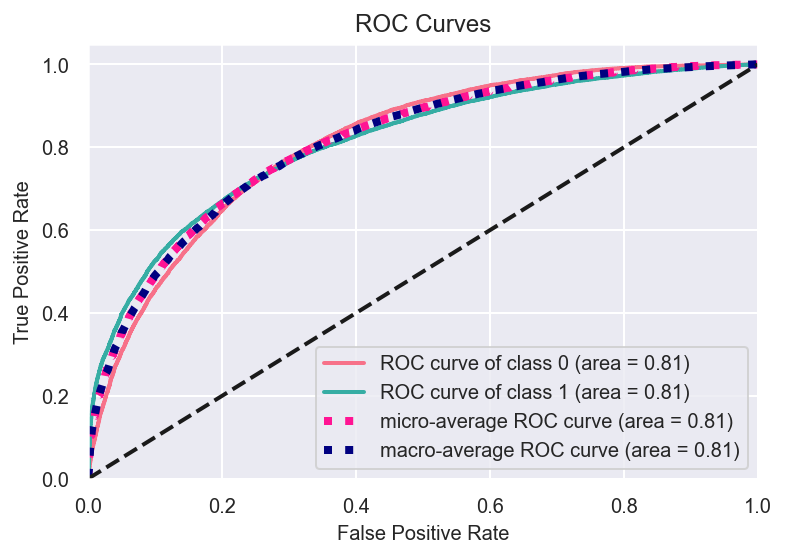

In [53]:
skplt.metrics.plot_roc(y5_train, probabilities_train, cmap=cmap)
plt.show()

The receiver operating characteristic curve is another evaluation tool to see the performance of binary classification algorithms. It provides a graphical overal representation of classifier as a whole rather than a single value. 
Similary like with the graph above, the higher area under the curve, higher AUC score the better classifier performs. 
